# MEG Device  --> data

In [ ]:
# MEGIN/Elekta neuromag vectorview and triux(.fif)
# Artemis123(.bin)
# 4-D neuroimaging/BTI data(dir)
# CTF data(dir)
# CTF polhemus data
# Ricoh/KIT MEG system data(.con/.sqd)
# Fieldtrip MEG/eeg data(.mat)


# EEG --> data

In [ ]:
# brainvision(.vhdr, .vmrk, .eeg)
# european data format(.edf)
# Biosemi data format(.bdf)
# General data format(.gdf)
# neuroscan cnt(.cnt)\
# EGI simple binary(.egi)
# EGI MFF(.mff)
# EEGLAB files(.set, .fdt)
# Nicolet(.data)
# eximia eeg data(.nxe)
# persyst EEG data(.lay, .dat)
# hihon kohden EEG data(.eeg, .21e, .pnt, .log)
# XDF data(.xdf, .xdfz)


# fIRS devices --> data

In [ ]:
# SNIRF(.snirf)
# NIRx(directory or hdr)
# Hitachi(.csv)
# Frequency domain devices : boxy(.txt)

In [ ]:
# One subject, 2 acquisition runs 6 minutes each.
# Each run contains 200 regular beeps and 40 easy deviant beeps.
# Random ISI: between 0.7s and 1.7s seconds, uniformly distributed.
# Button pressed when detecting a deviant with the right index finger.

In [1]:
import os.path as op
import pandas as pd
import numpy as np

import mne
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
use_precomputed = True

In [ ]:
# data 
# The data was collected with a CTF 275 system at 2400 Hz and low-pass filtered at 600 Hz. 

In [3]:
data_path = bst_auditory.data_path()

subject = 'bst_auditory'
subjects_dir = op.join(data_path, 'subjects')

raw_fname1 = op.join(data_path, 'MEG', subject, 'S01_AEF_20131218_01.ds')
raw_fname2 = op.join(data_path, 'MEG', subject, 'S01_AEF_20131218_02.ds')
erm_fname = op.join(data_path, 'MEG', subject, 'S01_Noise_20131218_01.ds')

Using default location ~/mne_data for bst_auditory...

License
-------
This tutorial dataset (EEG and MRI data) remains a property of the MEG Lab,
McConnell Brain Imaging Center, Montreal Neurological Institute,
McGill University, Canada. Its use and transfer outside the Brainstorm
tutorial, e.g. for research purposes, is prohibited without written consent
from the MEG Lab.

If you reference this dataset in your publications, please:

    1) acknowledge its authors: Elizabeth Bock, Esther Florin, Francois Tadel
       and Sylvain Baillet, and
    2) cite Brainstorm as indicated on the website:
       http://neuroimage.usc.edu/brainstorm

For questions, please contact Francois Tadel (francois.tadel@mcgill.ca).
Agree (y/[n])? y


100%|█████████████████████████████████████| 1.64G/1.64G [00:00<00:00, 1.81TB/s]
Untarring contents of '/Users/DanDan/mne_data/bst_auditory.tar.gz' to '/Users/DanDan/mne_data/MNE-brainstorm-data'


In [4]:
raw = read_raw_ctf(raw_fname1)
n_times_run1 = raw.n_times

# Here we ignore that these have different device<->head transforms
mne.io.concatenate_raws(
    [raw, read_raw_ctf(raw_fname2)], on_mismatch='ignore')
raw_erm = read_raw_ctf(erm_fname)

ds directory : /Users/DanDan/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26    0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26    0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00   -0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/Users/DanDan/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    5 extra points added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/DanDan/mne_

In [ ]:
# The data array consists of 274 MEG axial gradiometers, 26 MEG reference sensors and 2 EEG electrodes (Cz and Pz). In addition:
# 1 stim channel for marking presentation times for the stimuli
# 1 audio channel for the sent signal
# 1 response channel for recording the button presses
# 1 ECG bipolar
# 2 EOG bipolar (vertical and horizontal)
# 12 head tracking channels
# 20 unused channels

In [5]:
raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog', 'ECG': 'ecg'})
if not use_precomputed:
    # Leave out the two EEG channels for easier computation of forward.
    raw.pick(['meg', 'stim', 'misc', 'eog', 'ecg']).load_data()

In [6]:
annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1, 2]:
    csv_fname = op.join(data_path, 'MEG', 'bst_auditory',
                        'events_bad_0%s.csv' % idx)
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

saccades_events = df[df['label'] == 'saccade'].values[:, :3].astype(int)

# Conversion from samples to times:
onsets = annotations_df['onset'].values / raw.info['sfreq']
durations = annotations_df['duration'].values / raw.info['sfreq']
descriptions = annotations_df['label'].values

annotations = mne.Annotations(onsets, durations, descriptions)
raw.set_annotations(annotations)
del onsets, durations, descriptions

Events from run 1:
     onset  duration  id label
0     7625      2776   1   BAD
1   142459       892   1   BAD
2   216954       460   1   BAD
3   345135      5816   1   BAD
4   357687      1053   1   BAD
5   409101      3736   1   BAD
6   461110       179   1   BAD
7   479866       426   1   BAD
8   764914     11500   1   BAD
9   798174      6589   1   BAD
10  846880      5383   1   BAD
11  858863      5136   1   BAD
Events from run 2:
     onset  duration  id    label
0        9      5583   1      BAD
1     9256      3114   1      BAD
2    14287      3456   1      BAD
3   116432       228   1      BAD
4   134489      1329   1      BAD
5   464527      4727   1      BAD
6   494136      4519   1      BAD
7   749288       189   1      BAD
8   788623      7937   1      BAD
9    21179         0   1  saccade
10   72993         0   1  saccade
11  134527         0   1  saccade
12  196555         0   1  saccade
13  249894         0   1  saccade
14  343357         0   1  saccade
15  400771     

In [7]:
saccade_epochs = mne.Epochs(raw, saccades_events, 1, 0., 0.5, preload=True,
                            baseline=(None, None),
                            reject_by_annotation=False)

projs_saccade = mne.compute_proj_epochs(saccade_epochs, n_mag=1, n_eeg=0,
                                        desc_prefix='saccade')
if use_precomputed:
    proj_fname = op.join(data_path, 'MEG', 'bst_auditory',
                         'bst_auditory-eog-proj.fif')
    projs_eog = mne.read_proj(proj_fname)[0]
else:
    projs_eog, _ = mne.preprocessing.compute_proj_eog(raw.load_data(),
                                                      n_mag=1, n_eeg=0)
raw.add_proj(projs_saccade)
raw.add_proj(projs_eog)
del saccade_epochs, saccades_events, projs_eog, projs_saccade  # To save memory

Not setting metadata
16 matching events found
Setting baseline interval to [0.0, 0.5] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 1201 original time points ...
1 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


No gradiometers found. Forcing n_grad to 0
Adding projection: axial-saccade-PCA-01
    Read a total of 1 projection items:
        EOG-axial-998--0.200-0.200-PCA-01 (1 x 274)  idle
1 projection items deactivated
1 projection items deactivated


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


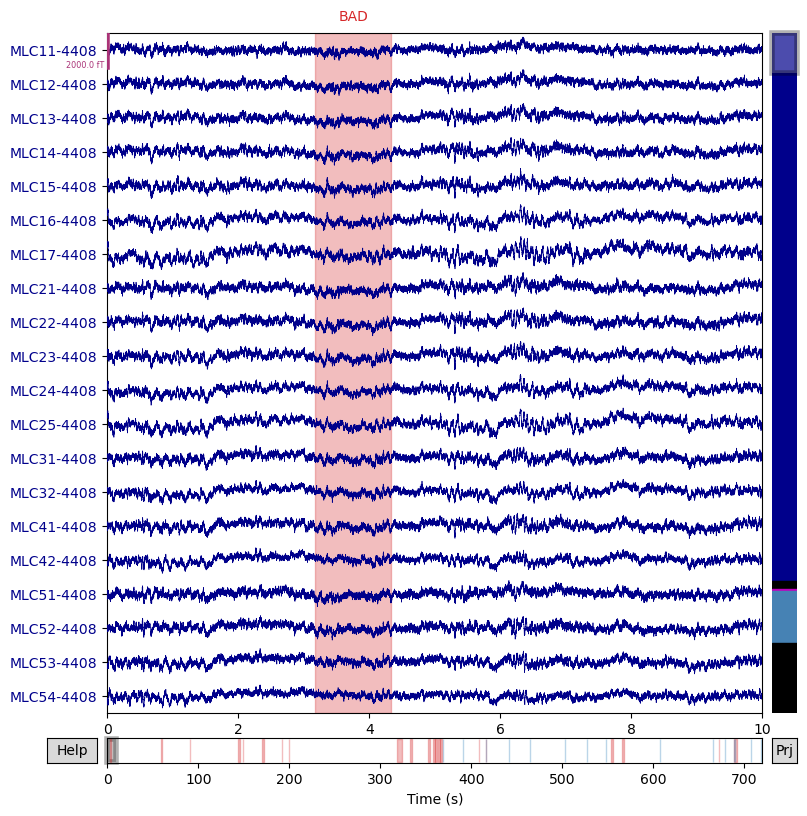

In [9]:
raw.plot(block=True);

In [10]:
# remove 60hz artiffact
if not use_precomputed:
    raw.plot_psd(tmax=np.inf, picks='meg')
    notches = np.arange(60, 181, 60)
    raw.notch_filter(notches, phase='zero-double', fir_design='firwin2')
    raw.plot_psd(tmax=np.inf, picks='meg')

In [11]:
# remove 100 hz
if not use_precomputed:
    raw.filter(None, 100., h_trans_bandwidth=0.5, filter_length='10s',
               phase='zero-double', fir_design='firwin2')

In [12]:
tmin, tmax = -0.1, 0.5
event_id = dict(standard=1, deviant=2)
reject = dict(mag=4e-12, eog=250e-6)
# find events
events = mne.find_events(raw, stim_channel='UPPT001')

480 events found
Event IDs: [1 2]


In [13]:
sound_data = raw[raw.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) > 2. * np.std(sound_data))[0]
min_diff = int(0.5 * raw.info['sfreq'])
diffs = np.concatenate([[min_diff + 1], np.diff(onsets)])
onsets = onsets[diffs > min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))
events[:, 0] = onsets
del sound_data, diffs

Trigger delay removed (μ ± σ): -14.0 ± 0.3 ms


In [14]:
raw.info['bads'] = ['MLO52-4408', 'MRT51-4408', 'MLO42-4408', 'MLO43-4408']

In [15]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=['meg', 'eog'],
                    baseline=(None, 0), reject=reject, preload=False,
                    proj=True)

Not setting metadata
480 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated


In [16]:
epochs.drop_bad()

# avoid warning about concatenating with annotations
epochs.set_annotations(None)

epochs_standard = mne.concatenate_epochs([epochs['standard'][range(40)],
                                          epochs['standard'][182:222]])
epochs_standard.load_data()  # Resampling to save memory.
epochs_standard.resample(600, npad='auto')
epochs_deviant = epochs['deviant'].load_data()
epochs_deviant.resample(600, npad='auto')
del epochs

Loading data for 480 events and 1441 original time points ...
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on MAG : ['MLP52-4408']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on MAG : ['MLP52-4408']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based

In [17]:
evoked_std = epochs_standard.average()
evoked_dev = epochs_deviant.average()
del epochs_standard, epochs_deviant

In [18]:
# remove power line artifacts 50hz - 60 hz
for evoked in (evoked_std, evoked_dev):
    evoked.filter(l_freq=None, h_freq=40., fir_design='firwin')

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.332 sec)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.332 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


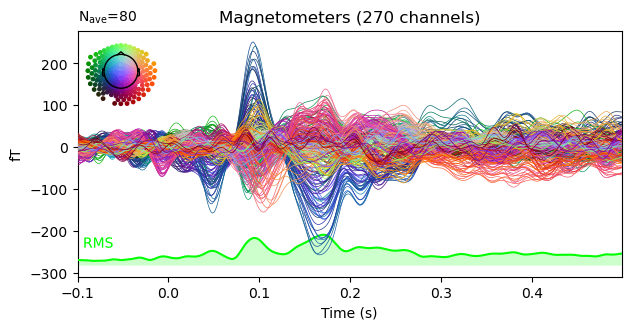

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


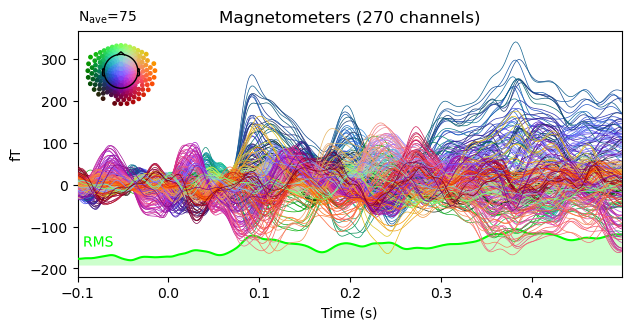

In [20]:
evoked_std.plot(window_title='Standard', gfp=True, time_unit='s')
evoked_dev.plot(window_title='Deviant', gfp=True, time_unit='s');

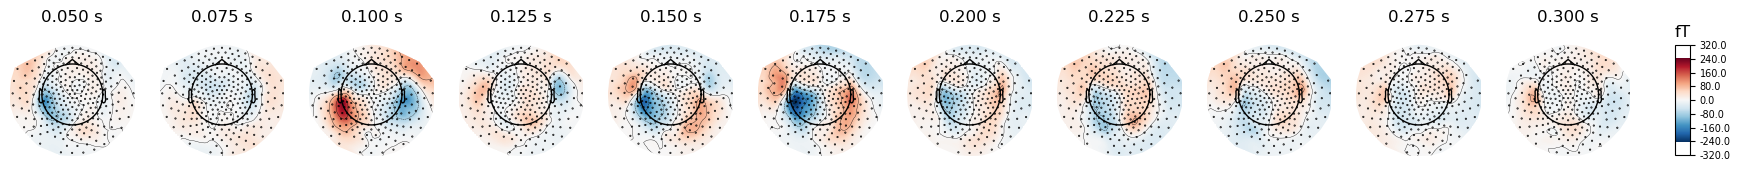

Text(0.5, 0.98, 'Standard')

In [21]:
times = np.arange(0.05, 0.301, 0.025)
fig = evoked_std.plot_topomap(times=times)
fig.suptitle('Standard')

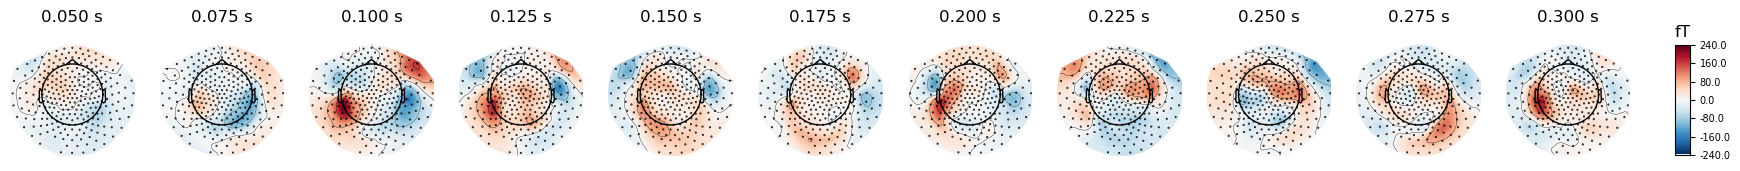

Text(0.5, 0.98, 'Deviant')

In [22]:
fig = evoked_dev.plot_topomap(times=times)
fig.suptitle('Deviant')

In [ ]:
# We can see the MMN effect more clearly by looking at the difference between the two conditions. 
# P50 and N100 are no longer visible, but MMN/P200 and P300 are emphasised.

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


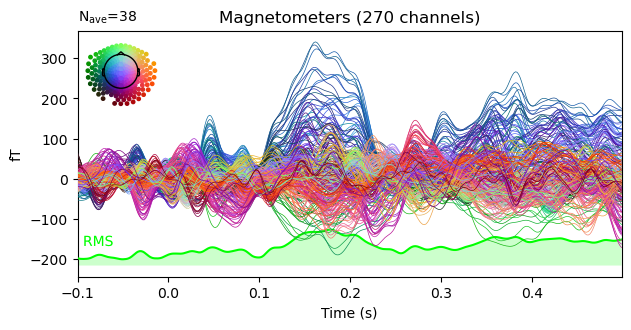

In [24]:
evoked_difference = combine_evoked([evoked_dev, evoked_std], weights=[1, -1])
evoked_difference.plot(window_title='Difference', gfp=True, time_unit='s');

Using up to 150 segments
Number of samples used : 72000
[done]
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 1.7e-14 (2.2e-16 eps * 274 dim * 0.27  max singular value)
    Estimated rank (mag): 274
    MAG: rank 274 computed from 274 data channels with 0 projectors


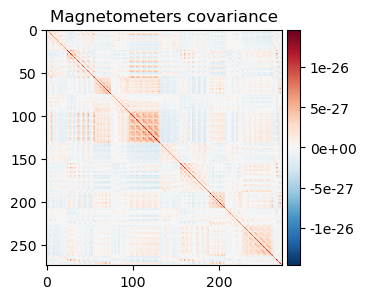

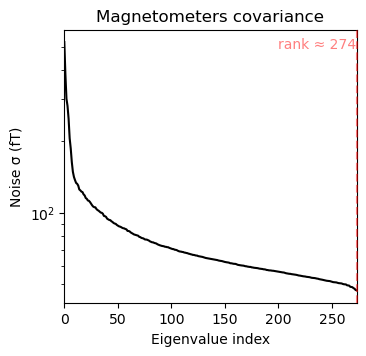

In [25]:
reject = dict(mag=4e-12)
cov = mne.compute_raw_covariance(raw_erm, reject=reject)
cov.plot(raw_erm.info)
del raw_erm

In [38]:
trans_fname = op.join(data_path, 'MEG', 'bst_auditory',
                      'bst_auditory-trans.fif')
trans = mne.read_trans(trans_fname)

In [39]:
if use_precomputed:
    fwd_fname = op.join(data_path, 'MEG', 'bst_auditory',
                        'bst_auditory-meg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
else:
    src = mne.setup_source_space(subject, spacing='ico4',
                                 subjects_dir=subjects_dir, overwrite=True)
    model = mne.make_bem_model(subject=subject, ico=4, conductivity=[0.3],
                               subjects_dir=subjects_dir)
    bem = mne.make_bem_solution(model)
    fwd = mne.make_forward_solution(evoked_std.info, trans=trans, src=src,
                                    bem=bem)

inv = mne.minimum_norm.make_inverse_operator(evoked_std.info, fwd, cov)
snr = 3.0
lambda2 = 1.0 / snr ** 2
del fwd

Reading forward solution from /Users/DanDan/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/bst_auditory-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 270 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 270 channels.
    270 out of 

In [50]:
stc_standard = mne.minimum_norm.apply_inverse(evoked_std, inv, lambda2, 'dSPM', pick_ori = 'vector')

Removing 5 compensators from info because not all compensation channels were picked.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 80
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 2)
    Created the whitener using a noise covariance matrix with rank 268 (2 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "standard"...
    Picked 270 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  97.0% variance
    dSPM...
[done]


In [41]:
stc_standard

<SourceEstimate | 8196 vertices, subject : bst_auditory, tmin : -100.0 (ms), tmax : 498.3333333333334 (ms), tstep : 1.6666666666666667 (ms), data shape : (8196, 360), ~22.6 MB>

Using control points [ 4.80289065  5.69025561 15.89954824]


<IPython.core.display.Javascript object>


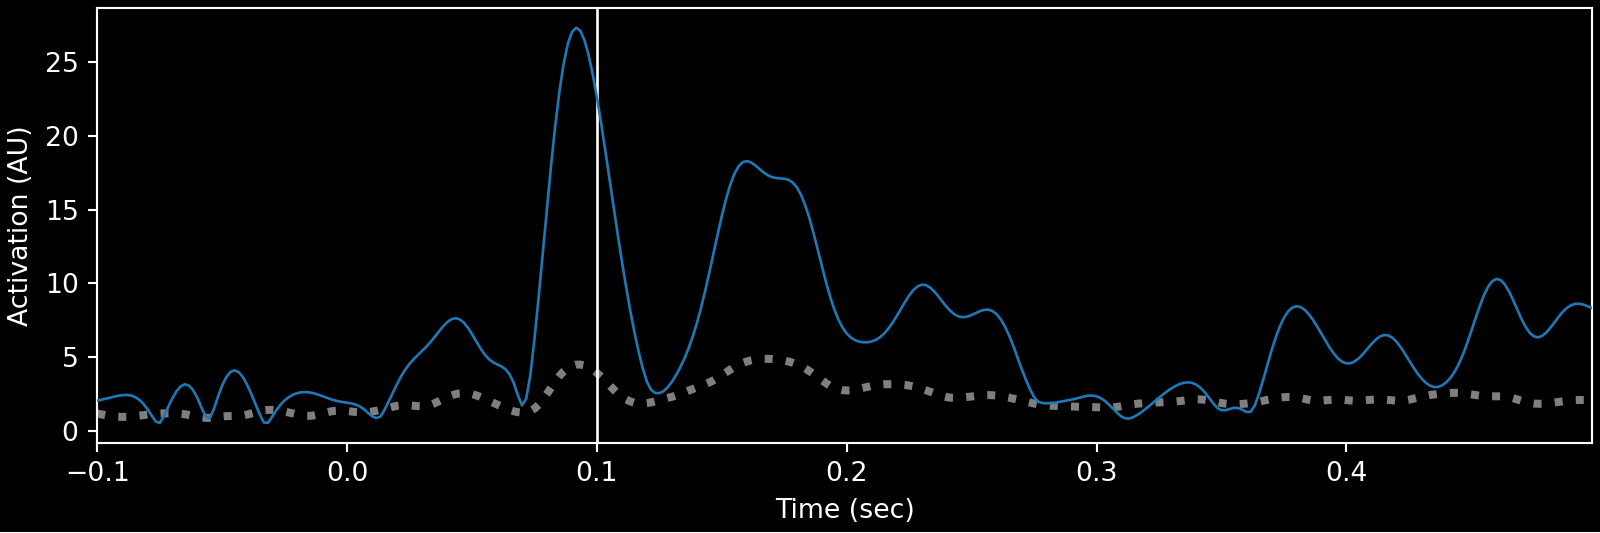

<IPython.core.display.Javascript object>


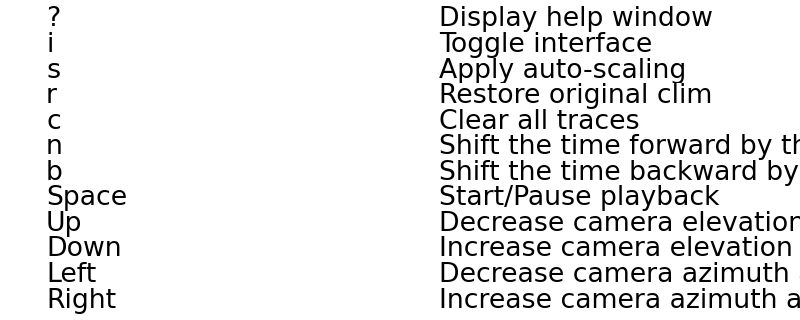

In [51]:
brain = stc_standard.plot(subjects_dir=subjects_dir, 
                          subject=subject,
                          hemi='lh',
                          initial_time = 0.1,
#                          smoothing_steps = smoothing_steps
                         )
# del stc_standard, brain